In [1]:
!pip install pathway bokeh --quiet

In [3]:
import os
import numpy as np
import pandas as pd
import pathway as pw
from math import radians, cos, sin, asin, sqrt

os.makedirs("output", exist_ok=True)

BASE_PRICE = 10
PRICE_MIN = 5
PRICE_MAX = 20
ALPHA = 2.0

In [5]:
def model_1_linear(price, occupancy, capacity):
    return np.clip(price + ALPHA * (occupancy / capacity), PRICE_MIN, PRICE_MAX)

def model_2_demand(occupancy, capacity, queue, traffic, special_day, vehicle_type):
    demand = (
        1.0 * (occupancy / capacity) +
        0.3 * queue -
        0.4 * traffic +
        0.8 * special_day +
        0.5 * {"bike": 0.8, "car": 1.0, "truck": 1.2}.get(vehicle_type, 1.0)
    )
    demand_norm = np.tanh(demand / 5)
    return np.clip(BASE_PRICE * (1 + 0.5 * demand_norm), PRICE_MIN, PRICE_MAX)

def model_3_competitive(current_price, nearby_prices, occupancy):
    avg_competitor_price = np.mean(nearby_prices)
    if occupancy > 0.9 and current_price > avg_competitor_price:
        return max(current_price * 0.9, PRICE_MIN), True
    elif occupancy < 0.6 and current_price < avg_competitor_price:
        return min(current_price * 1.1, PRICE_MAX), False
    return current_price, False

In [7]:
class ParkingSchema(pw.Schema):
    lot_id: str
    timestamp: str
    lat: float
    lon: float
    capacity: int
    occupancy: int
    queue: float
    traffic: float
    is_special_day: int
    vehicle_type: str


In [9]:
import pandas as pd
import os

os.makedirs("data", exist_ok=True)

df_raw = pd.read_csv("dataset.csv", skiprows=1, header=None)

df_cleaned = pd.DataFrame({
    "lot_id": df_raw[1],
    "timestamp": df_raw[10] + " " + df_raw[11],
    "lat": df_raw[3].astype(float),
    "lon": df_raw[4].astype(float),
    "capacity": df_raw[2].astype(int),
    "occupancy": df_raw[5].astype(int),
    "queue": df_raw[8].astype(float),
    "traffic": df_raw[7].map({"low": 1, "average": 2, "high": 3}).astype(float),
    "is_special_day": df_raw[9].astype(int),
    "vehicle_type": df_raw[6]
})

df_cleaned.to_csv("dataset.csv", index=False)

In [11]:
data = pw.io.csv.read("dataset.csv", schema=ParkingSchema, mode="static")

In [13]:
pricing_table = data.select(
    lot_id=pw.this.lot_id,
    timestamp=pw.this.timestamp,

    price_model_1=pw.apply(
        model_1_linear,
        BASE_PRICE,
        pw.this.occupancy,
        pw.this.capacity
    ),

    price_model_2=pw.apply(
        model_2_demand,
        pw.this.occupancy,
        pw.this.capacity,
        pw.this.queue,
        pw.this.traffic,
        pw.this.is_special_day,
        pw.this.vehicle_type
    ),

    price_model_3=pw.apply(
        lambda price2, occ: model_3_competitive(price2, [price2 * 0.9, price2 * 1.1, price2], occ)[0],
        pw.apply(
            model_2_demand,
            pw.this.occupancy,
            pw.this.capacity,
            pw.this.queue,
            pw.this.traffic,
            pw.this.is_special_day,
            pw.this.vehicle_type
        ),
        pw.this.occupancy / pw.this.capacity
    ),

    reroute_flag=pw.apply(
        lambda price2, occ: model_3_competitive(price2, [price2 * 0.9, price2 * 1.1, price2], occ)[1],
        pw.apply(
            model_2_demand,
            pw.this.occupancy,
            pw.this.capacity,
            pw.this.queue,
            pw.this.traffic,
            pw.this.is_special_day,
            pw.this.vehicle_type
        ),
        pw.this.occupancy / pw.this.capacity
    )
)


In [15]:
pw.io.jsonlines.write(pricing_table, "output/pricing.jsonl")

/opt/anaconda3/lib/python3.12/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [17]:
pw.run()

Output()

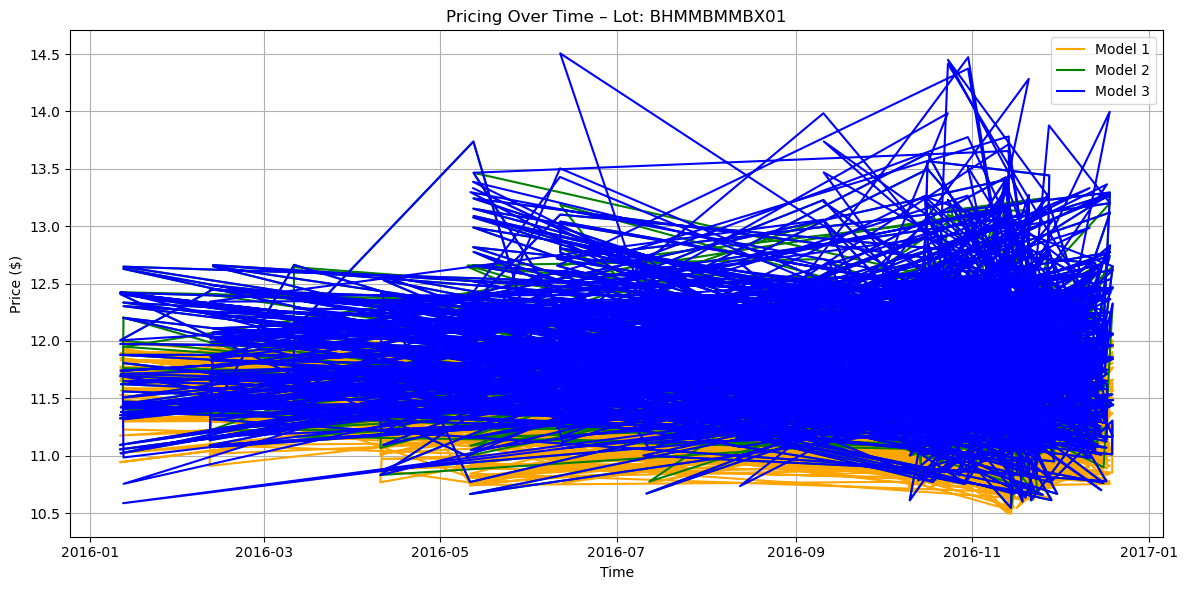

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_json("output/pricing.jsonl", lines=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])

lot = df['lot_id'].unique()[0]
subset = df[df['lot_id'] == lot]

plt.figure(figsize=(12, 6))
plt.plot(subset['timestamp'], subset['price_model_1'], label='Model 1', color='orange')
plt.plot(subset['timestamp'], subset['price_model_2'], label='Model 2', color='green')
plt.plot(subset['timestamp'], subset['price_model_3'], label='Model 3', color='blue')

plt.title(f'Pricing Over Time – Lot: {lot}')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
df[['price_model_1', 'price_model_2', 'price_model_3']].describe()

,price_model_1,price_model_2,price_model_3
count,18368.000000,18368.000000,18368.000000
mean,11.018237,11.672140,11.872107
std,0.492286,0.611438,0.741454
min,10.006932,9.924269,9.924269
25%,10.614221,11.220249,11.345695
50%,10.992248,11.621043,11.808809
75%,11.402062,12.079362,12.302233
max,12.082687,13.998538,15.078353


In [23]:
df['reroute_flag'].value_counts()

reroute_flag
False    18171
True       197
Name: count, dtype: int64

In [25]:
df[['price_model_1', 'price_model_2', 'price_model_3']].applymap(lambda x: 5 <= x <= 20).all()

/var/folders/c4/_z596k316gb3p9_k08gv1tm80000gn/T/ipykernel_40740/2225183645.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['price_model_1', 'price_model_2', 'price_model_3']].applymap(lambda x: 5 <= x <= 20).all()


price_model_1    True
price_model_2    True
price_model_3    True
dtype: bool

In [27]:
df['delta_1_vs_3'] = df['price_model_3'] - df['price_model_1']
df[['lot_id', 'timestamp', 'price_model_1', 'price_model_3', 'delta_1_vs_3']].sort_values(by='delta_1_vs_3', ascending=False).head()

,lot_id,timestamp,price_model_1,price_model_3,delta_1_vs_3
13037,Others-CCCPS135a,2016-06-11 12:26:00,10.494463,14.856010,4.361547
7,Others-CCCPS202,2016-11-20 12:01:00,10.525707,14.808255,4.282549
15969,Others-CCCPS135a,2016-11-13 12:27:00,10.557816,14.817428,4.259612
11821,Others-CCCPS119a,2016-11-13 12:00:00,10.337496,14.570075,4.232579
14959,Others-CCCPS135a,2016-11-20 12:01:00,10.601597,14.829870,4.228273


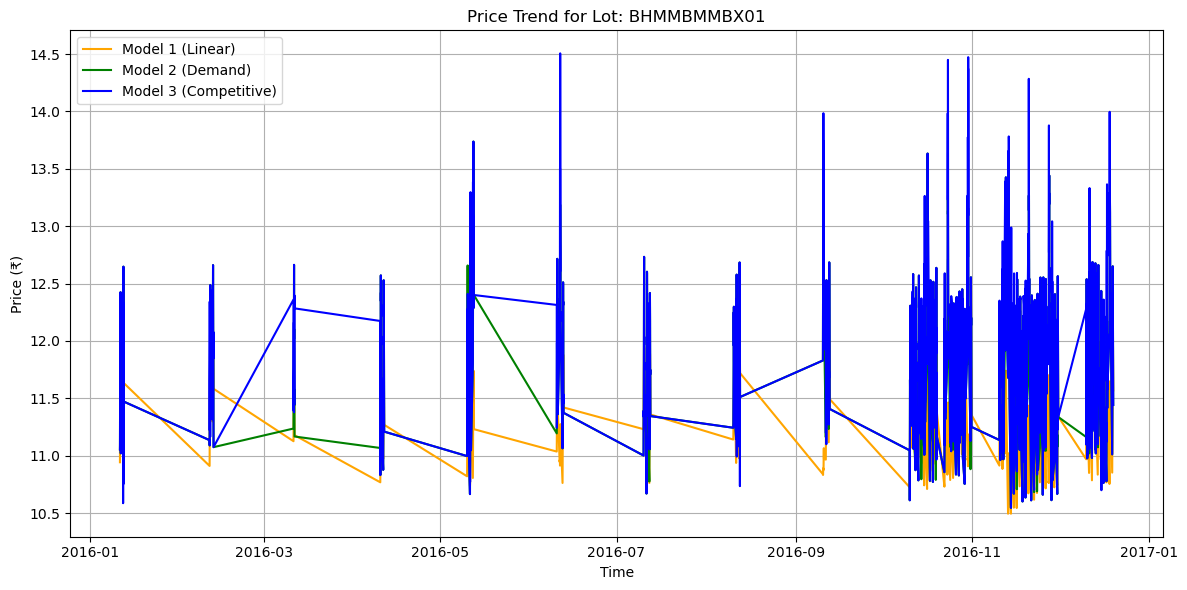

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("output/pricing.jsonl", lines=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])

lot = df['lot_id'].unique()[0]
subset = df[df['lot_id'] == lot].sort_values(by="timestamp")

plt.figure(figsize=(12, 6))
plt.plot(subset['timestamp'], subset['price_model_1'], label='Model 1 (Linear)', color='orange')
plt.plot(subset['timestamp'], subset['price_model_2'], label='Model 2 (Demand)', color='green')
plt.plot(subset['timestamp'], subset['price_model_3'], label='Model 3 (Competitive)', color='blue')

plt.title(f'Price Trend for Lot: {lot}')
plt.xlabel('Time')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category10
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook()

subset = df[df['lot_id'] == lot].sort_values('timestamp')

p = figure(x_axis_type='datetime', title=f"Dynamic Pricing Comparison – Lot: {lot}", 
           width=900, height=400, tools="pan,wheel_zoom,box_zoom,reset,save")

colors = Category10[3]
p.line(subset['timestamp'], subset['price_model_1'], color=colors[0], legend_label="Model 1", line_width=2)
p.line(subset['timestamp'], subset['price_model_2'], color=colors[1], legend_label="Model 2", line_width=2)
p.line(subset['timestamp'], subset['price_model_3'], color=colors[2], legend_label="Model 3", line_width=2)

p.add_tools(HoverTool(tooltips=[
    ("Time", "@x{%F %H:%M}"),
    ("Price", "$y")
], formatters={'@x': 'datetime'}))

p.xaxis.axis_label = "Timestamp"
p.yaxis.axis_label = "Price (₹)"
p.legend.location = "top_left"

show(p)

Loading BokehJS ...